In [1]:
import pandas as pd
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from collections import Counter

def load_dataset(filepath):
    df = pd.read_csv(filepath, delimiter='\t', header=None, usecols=[1, 2], names=['label', 'statement'])
    df['label'] = df['label'].apply(lambda x: 1 if x in ['false', 'barely-true', 'pants-fire','half-true'] else 0)
    return df

train_df = load_dataset('train.tsv')
test_df = load_dataset('test.tsv')
valid_df = load_dataset('valid.tsv')

# Extract sentences and labels
train_sentences = train_df['statement'].values
train_labels = train_df['label'].values

test_sentences = test_df['statement'].values
test_labels = test_df['label'].values

valid_sentences = valid_df['statement'].values
valid_labels = valid_df['label'].values

In [2]:
# Tokenization
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Build vocab
vocab = build_vocab_from_iterator(yield_tokens(train_sentences), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Encode text and labels
def text_pipeline(x):
    return vocab(tokenizer(x))

def label_pipeline(x):
    return int(x)

# Create a custom dataset
class NewsDataset(Dataset):
    def __init__(self, sentences, labels, text_pipeline, label_pipeline):
        self.sentences = sentences
        self.labels = labels
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        text = self.text_pipeline(self.sentences.iloc[idx])
        label = self.label_pipeline(self.labels.iloc[idx])
        return torch.tensor(text, dtype=torch.int64).clone().detach(), torch.tensor(label, dtype=torch.int64)


from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    text_list, label_list = [], []
    for (_text, _label) in batch:
        processed_text = _text
        text_list.append(processed_text)
        label_list.append(_label)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)  # Pad your sequences here
    label_list = torch.stack(label_list)
    return text_list, label_list

# Create datasets
train_dataset = NewsDataset(train_df['statement'], train_df['label'], text_pipeline, label_pipeline)
test_dataset = NewsDataset(test_df['statement'], test_df['label'], text_pipeline, label_pipeline)
valid_dataset = NewsDataset(valid_df['statement'], valid_df['label'], text_pipeline, label_pipeline)

# Create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)



In [3]:
torch.cuda.is_available()

True

# RNN

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        hidden = torch.squeeze(hidden, 0)  # squeeze the first dimension to match the shape for linear layer
        logits = self.fc(hidden)
        return logits

# Parameters
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 128
output_dim = 2  # Binary classification

rnn_model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim).cuda()

# Print model architecture
print(rnn_model)


RNNModel(
  (embedding): Embedding(13512, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [10]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.0001)

# Training function
def train_rnn(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for text, labels in iterator:
        text,labels = text.cuda(),labels.cuda()
        optimizer.zero_grad()
        predictions = model(text)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for text, labels in iterator:
            text,labels = text.cuda(),labels.cuda()
            predictions = model(text)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Training loop
N_EPOCHS = 10
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_rnn(rnn_model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(rnn_model, valid_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
#         torch.save(rnn_model.state_dict(), 'rnn_model.pt')

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

# Load the best model
# rnn_model.load_state_dict(torch.load('rnn_model.pt'))

# Evaluate on test set
test_loss, test_acc = evaluate(rnn_model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


Epoch: 01 | Train Loss: 0.662 | Train Acc: 63.44% | Valid Loss: 0.635 | Valid Acc: 67.37%
Epoch: 02 | Train Loss: 0.655 | Train Acc: 64.34% | Valid Loss: 0.633 | Valid Acc: 67.37%
Epoch: 03 | Train Loss: 0.655 | Train Acc: 64.19% | Valid Loss: 0.634 | Valid Acc: 67.29%
Epoch: 04 | Train Loss: 0.654 | Train Acc: 64.45% | Valid Loss: 0.635 | Valid Acc: 67.29%
Epoch: 05 | Train Loss: 0.653 | Train Acc: 64.35% | Valid Loss: 0.639 | Valid Acc: 66.74%
Epoch: 06 | Train Loss: 0.653 | Train Acc: 64.41% | Valid Loss: 0.633 | Valid Acc: 67.06%
Epoch: 07 | Train Loss: 0.651 | Train Acc: 64.33% | Valid Loss: 0.634 | Valid Acc: 67.21%
Epoch: 08 | Train Loss: 0.652 | Train Acc: 64.40% | Valid Loss: 0.634 | Valid Acc: 67.13%
Epoch: 09 | Train Loss: 0.650 | Train Acc: 64.44% | Valid Loss: 0.662 | Valid Acc: 66.20%
Epoch: 10 | Train Loss: 0.650 | Train Acc: 64.48% | Valid Loss: 0.636 | Valid Acc: 66.98%
Test Loss: 0.653 | Test Acc: 64.41%


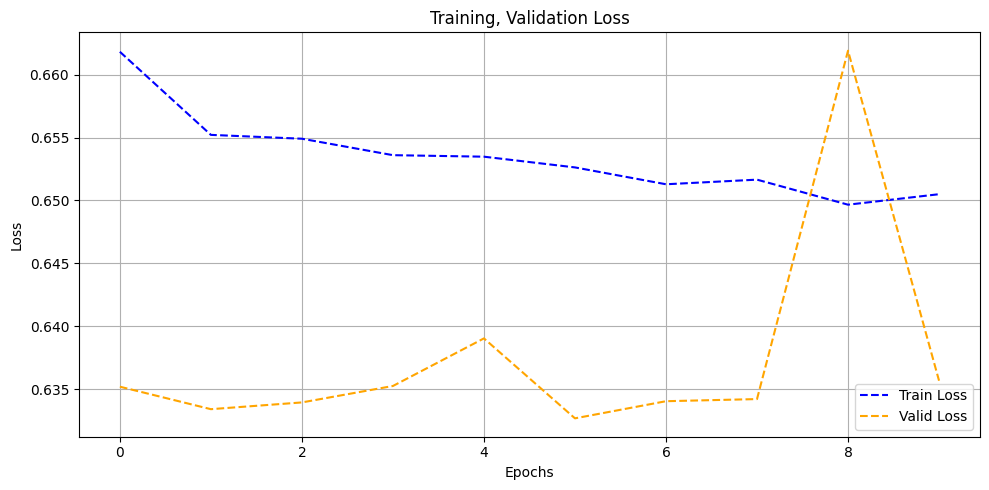

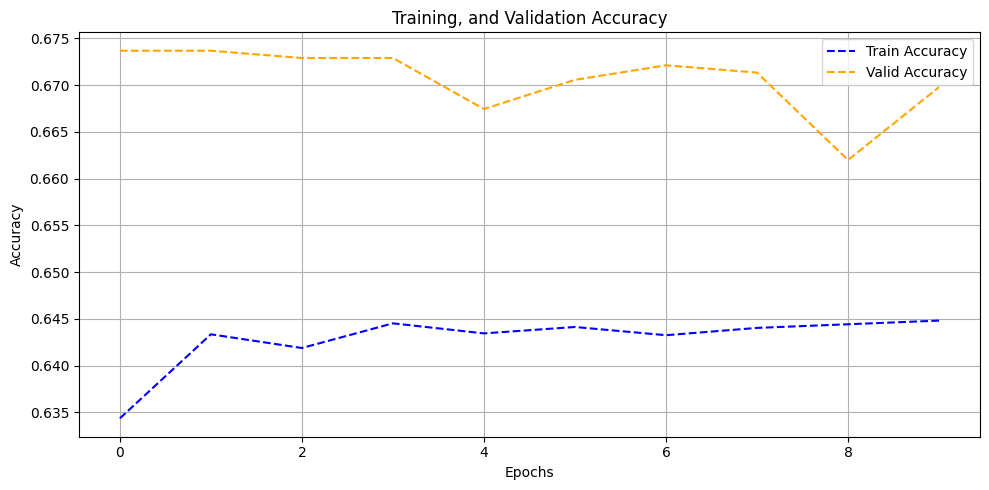

In [11]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='dashed', linewidth=1.5)
plt.plot(valid_losses, label='Valid Loss', color='orange', linestyle='dashed', linewidth=1.5)
# plt.plot(len(train_losses)-1, test_loss, marker='x', markersize=10, color='red', label='Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or display the plot
# plt.savefig('loss_plot.png')
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy', color='blue', linestyle='dashed', linewidth=1.5)
plt.plot(valid_accs, label='Valid Accuracy', color='orange', linestyle='dashed', linewidth=1.5)
# plt.plot(len(train_accs)-1, test_acc, marker='x', markersize=10, color='red', label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or display the plot
# plt.savefig('accuracy_plot.png')
plt.show()


# LSTM

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))

        output, _ = self.rnn(embedded)

        # Max pooling over the sequence
        pooled, _ = torch.max(output, 1)

        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        return logits

# Parameters
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 128
num_layers = 2  # Number of RNN layers
output_dim = 2

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim).cuda()

# Print model architecture
print(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training function
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for text, labels in iterator:
        text, labels = text.cuda(),labels.cuda()
        optimizer.zero_grad()
        predictions = model(text)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for text, labels in iterator:
            text, labels = text.cuda(),labels.cuda()
            predictions = model(text)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Function to calculate accuracy
def binary_accuracy(preds, y):
    rounded_preds = torch.argmax(F.softmax(preds, dim=1), dim=1)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Training loop
N_EPOCHS = 10
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'rnn_model.pt')

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

# Load the best model
# model.load_state_dict(torch.load('rnn_model.pt'))

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


LSTMModel(
  (embedding): Embedding(13512, 100)
  (rnn): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch: 01 | Train Loss: 0.654 | Train Acc: 64.27% | Valid Loss: 0.640 | Valid Acc: 67.29%
Epoch: 02 | Train Loss: 0.647 | Train Acc: 64.45% | Valid Loss: 0.621 | Valid Acc: 67.45%
Epoch: 03 | Train Loss: 0.641 | Train Acc: 64.81% | Valid Loss: 0.620 | Valid Acc: 67.37%
Epoch: 04 | Train Loss: 0.634 | Train Acc: 64.99% | Valid Loss: 0.616 | Valid Acc: 66.20%
Epoch: 05 | Train Loss: 0.632 | Train Acc: 64.78% | Valid Loss: 0.611 | Valid Acc: 67.99%
Epoch: 06 | Train Loss: 0.627 | Train Acc: 65.26% | Valid Loss: 0.614 | Valid Acc: 65.34%
Epoch: 07 | Train Loss: 0.622 | Train Acc: 65.65% | Valid Loss: 0.610 | Valid Acc: 67.06%
Epoch: 08 | Train Loss: 0.619 | Train Acc: 66.09% | Valid Loss: 0.613 | Valid Acc: 66.04%
Epoch: 09 | Train Loss: 0.614 | Train A

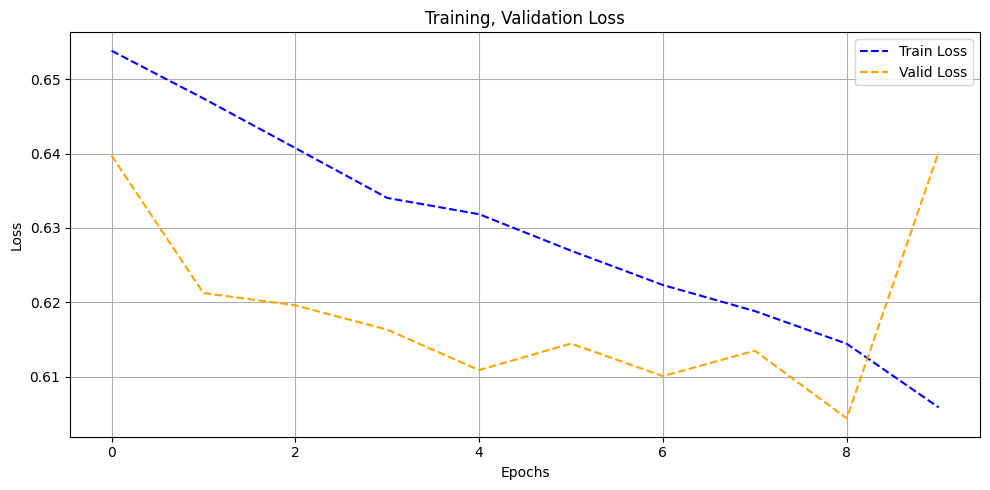

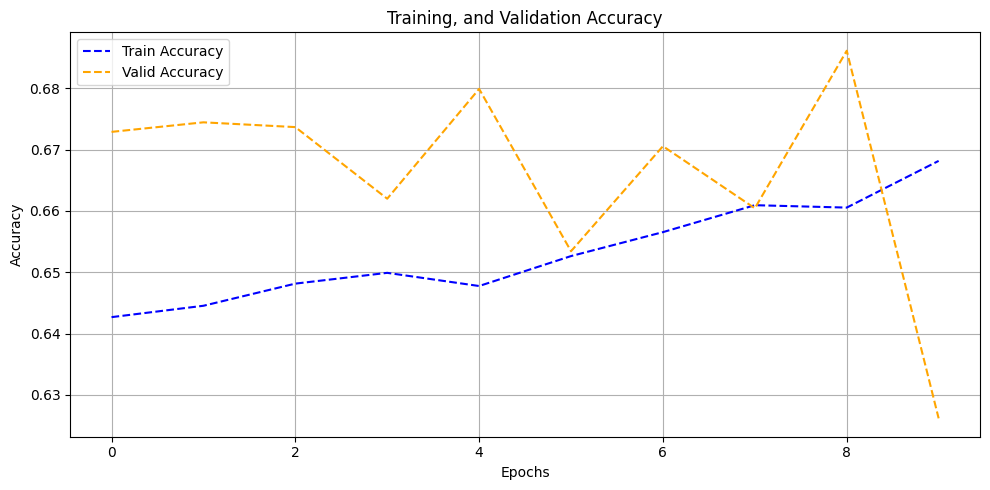

In [14]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='dashed', linewidth=1.5)
plt.plot(valid_losses, label='Valid Loss', color='orange', linestyle='dashed', linewidth=1.5)
# plt.plot(len(train_losses)-1, test_loss, marker='x', markersize=10, color='red', label='Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or display the plot
# plt.savefig('loss_plot.png')
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy', color='blue', linestyle='dashed', linewidth=1.5)
plt.plot(valid_accs, label='Valid Accuracy', color='orange', linestyle='dashed', linewidth=1.5)
# plt.plot(len(train_accs)-1, test_acc, marker='x', markersize=10, color='red', label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or display the plot
# plt.savefig('accuracy_plot.png')
plt.show()


# LSTM with early stopping

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))

        output, _ = self.rnn(embedded)

        # Max pooling over the sequence
        pooled, _ = torch.max(output, 1)

        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        return logits

# Parameters
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 128
num_layers = 2
output_dim = 2

LSTMmodel = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim).cuda()

print(LSTMmodel)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LSTMmodel.parameters(), lr=0.0001)

def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for text, labels in iterator:
        text, labels = text.cuda(), labels.cuda()
        optimizer.zero_grad()
        predictions = model(text)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for text, labels in iterator:
            text, labels = text.cuda(), labels.cuda()
            predictions = model(text)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def binary_accuracy(preds, y):
    rounded_preds = torch.argmax(F.softmax(preds, dim=1), dim=1)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Training loop with early stopping
N_EPOCHS = 10
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_valid_loss = float('inf')
patience = 3  # Number of epochs to wait if validation loss doesn't improve
patience_counter = 0

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(LSTMmodel, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(LSTMmodel, valid_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

        # Reset patience counter
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after epoch {epoch+1}.')
            break

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

# Load the best model
# model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on test set
test_loss, test_acc = evaluate(LSTMmodel, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


LSTMModel(
  (embedding): Embedding(13512, 100)
  (rnn): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch: 01 | Train Loss: 0.652 | Train Acc: 64.33% | Valid Loss: 0.635 | Valid Acc: 67.29%
Epoch: 02 | Train Loss: 0.646 | Train Acc: 64.42% | Valid Loss: 0.619 | Valid Acc: 67.60%
Epoch: 03 | Train Loss: 0.639 | Train Acc: 64.41% | Valid Loss: 0.629 | Valid Acc: 65.73%
Epoch: 04 | Train Loss: 0.631 | Train Acc: 64.93% | Valid Loss: 0.624 | Valid Acc: 65.11%
Epoch: 05 | Train Loss: 0.630 | Train Acc: 65.17% | Valid Loss: 0.609 | Valid Acc: 66.59%
Epoch: 06 | Train Loss: 0.624 | Train Acc: 65.65% | Valid Loss: 0.618 | Valid Acc: 66.36%
Epoch: 07 | Train Loss: 0.623 | Train Acc: 65.32% | Valid Loss: 0.614 | Valid Acc: 66.04%
Early stopping after epoch 8.
Test Loss: 0.632 | Test Acc: 62.62%


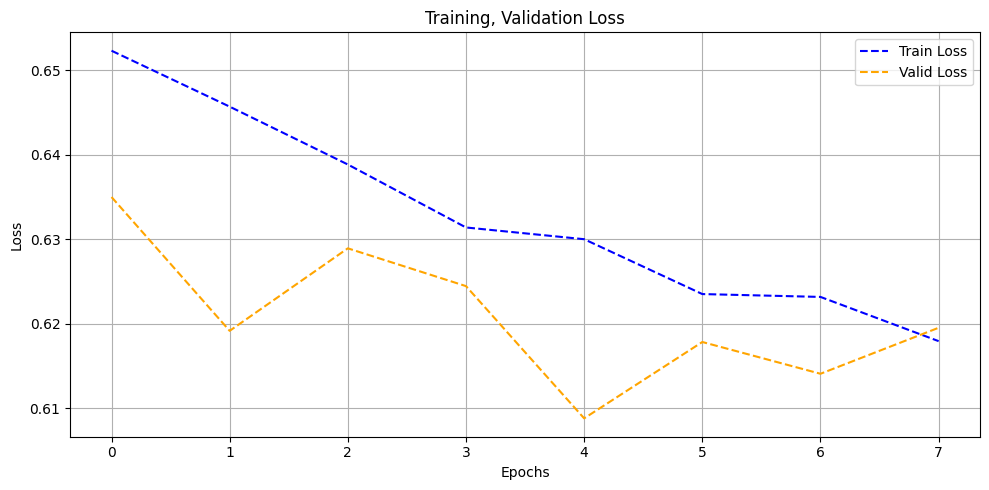

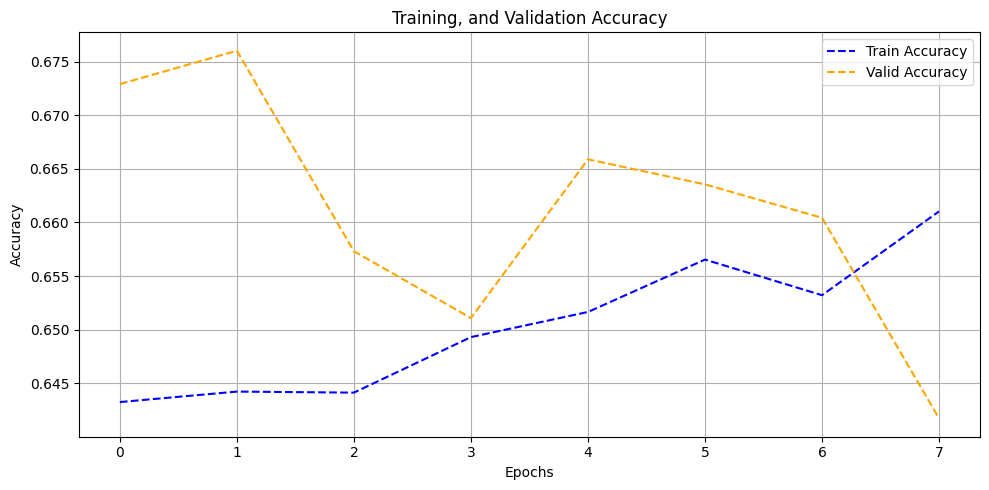

In [16]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='dashed', linewidth=1.5)
plt.plot(valid_losses, label='Valid Loss', color='orange', linestyle='dashed', linewidth=1.5)
# plt.plot(len(train_losses)-1, test_loss, marker='x', markersize=10, color='red', label='Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or display the plot
# plt.savefig('loss_plot.png')
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy', color='blue', linestyle='dashed', linewidth=1.5)
plt.plot(valid_accs, label='Valid Accuracy', color='orange', linestyle='dashed', linewidth=1.5)
# plt.plot(len(train_accs)-1, test_acc, marker='x', markersize=10, color='red', label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or display the plot
# plt.savefig('accuracy_plot.png')
plt.show()


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout=0.5):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        # Output shape: (batch_size, seq_len, embedding_dim)

        output, _ = self.rnn(embedded)
        # Output shape: (batch_size, seq_len, hidden_dim * 2) for bidirectional

        # Max pooling over the sequence
        pooled, _ = torch.max(output, 1)
        # Output shape: (batch_size, hidden_dim * 2)

        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        return logits

# Parameters
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 128
num_layers = 2  # Number of RNN layers
output_dim = 2  # Binary classification

# Instantiate the model and move to device
BiLSTMmodel = BiLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim).to(device)

# Print model architecture
print(BiLSTMmodel)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(BiLSTMmodel.parameters(), lr=0.001)

# Training function
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for text, labels in iterator:
        text,labels = text.cuda(),labels.cuda()
        optimizer.zero_grad()
        predictions = model(text)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for text, labels in iterator:
            text,labels = text.cuda(),labels.cuda()
            predictions = model(text)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Function to calculate accuracy
def binary_accuracy(preds, y):
    rounded_preds = torch.argmax(F.softmax(preds, dim=1), dim=1)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Training loop
N_EPOCHS = 10
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(BiLSTMmodel, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(BiLSTMmodel, valid_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'bi_rnn_model.pt')

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')


# Load the best model
# model.load_state_dict(torch.load('bi_rnn_model.pt'))

# Evaluate on test set
test_loss, test_acc = evaluate(BiLSTMmodel, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


BiLSTM(
  (embedding): Embedding(13512, 100)
  (rnn): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch: 01 | Train Loss: 0.652 | Train Acc: 63.99% | Valid Loss: 0.613 | Valid Acc: 67.37%
Epoch: 02 | Train Loss: 0.638 | Train Acc: 64.58% | Valid Loss: 0.607 | Valid Acc: 66.28%
Epoch: 03 | Train Loss: 0.621 | Train Acc: 65.34% | Valid Loss: 0.599 | Valid Acc: 67.21%
Epoch: 04 | Train Loss: 0.602 | Train Acc: 66.98% | Valid Loss: 0.598 | Valid Acc: 67.45%
Epoch: 05 | Train Loss: 0.581 | Train Acc: 69.51% | Valid Loss: 0.605 | Valid Acc: 65.03%
Epoch: 06 | Train Loss: 0.560 | Train Acc: 71.50% | Valid Loss: 0.617 | Valid Acc: 66.28%
Epoch: 07 | Train Loss: 0.543 | Train Acc: 72.74% | Valid Loss: 0.623 | Valid Acc: 65.73%
Epoch: 08 | Train Loss: 0.526 | Train Acc: 73.69% | Valid Loss: 0.647 | Valid Acc: 64.56%
Epoch: 09 | Train Loss: 0.501 | Train Acc:

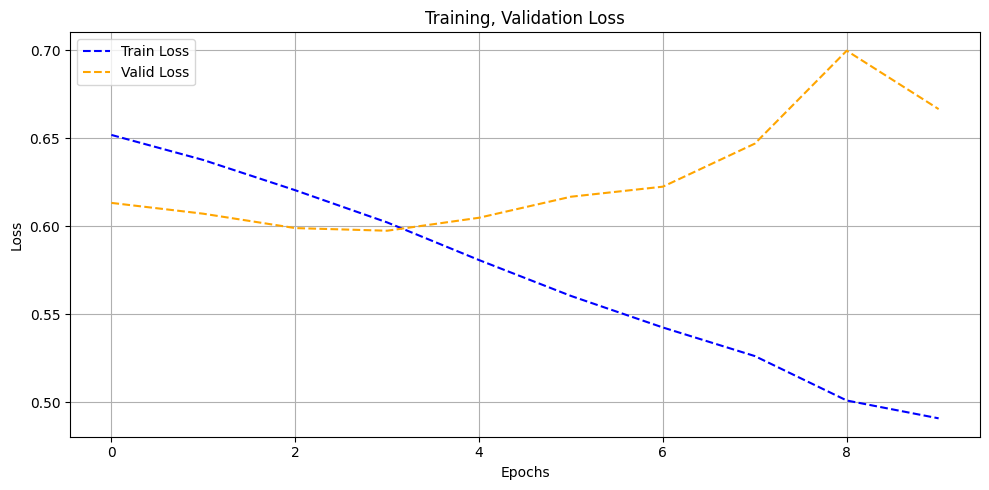

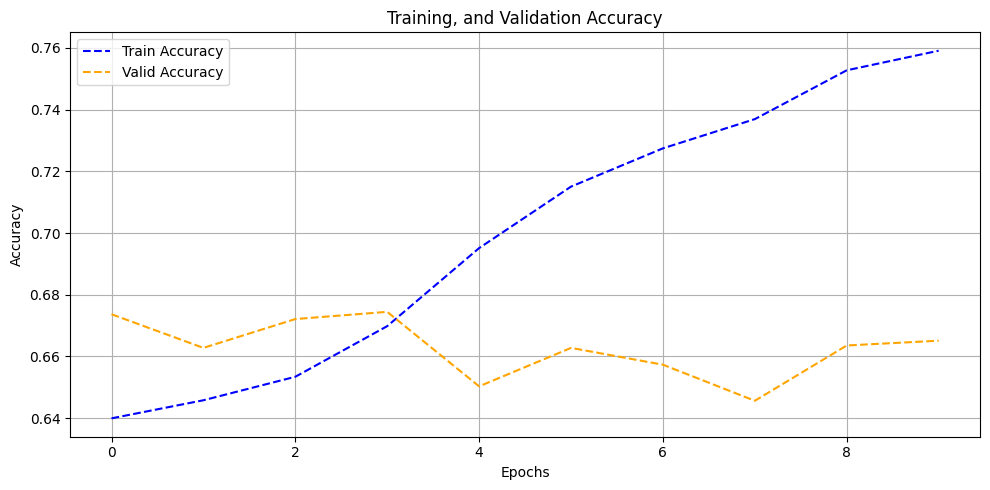

In [18]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='dashed', linewidth=1.5)
plt.plot(valid_losses, label='Valid Loss', color='orange', linestyle='dashed', linewidth=1.5)
# plt.plot(len(train_losses)-1, test_loss, marker='x', markersize=10, color='red', label='Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or display the plot
# plt.savefig('loss_plot.png')
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy', color='blue', linestyle='dashed', linewidth=1.5)
plt.plot(valid_accs, label='Valid Accuracy', color='orange', linestyle='dashed', linewidth=1.5)
# plt.plot(len(train_accs)-1, test_acc, marker='x', markersize=10, color='red', label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or display the plot
# plt.savefig('accuracy_plot.png')
plt.show()


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim))

    def forward(self, encoder_outputs):
        energy = torch.tanh(self.linear(encoder_outputs))
        energy = energy.permute(0, 2, 1) # to match shape
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        attention_scores = torch.bmm(v, energy).squeeze(1)
        attention_weights = F.softmax(attention_scores, dim=1)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        return context_vector

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout=0.5):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, _ = self.lstm(embedded)
        context_vector = self.attention(output)
        context_vector = context_vector.squeeze(1)
        logits = self.fc(context_vector)
        return logits

vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 128
num_layers = 2
output_dim = 2

BiLSTM_Attentionmodel = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim).to(device)

# Print model architecture
print(BiLSTM_Attentionmodel)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(BiLSTM_Attentionmodel.parameters(), lr=0.001)

def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for text, labels in iterator:
        text, labels = text.cuda(), labels.cuda()
        optimizer.zero_grad()
        predictions = model(text)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for text, labels in iterator:
            text, labels = text.cuda(), labels.cuda()
            predictions = model(text)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def binary_accuracy(preds, y):
    rounded_preds = torch.argmax(F.softmax(preds, dim=1), dim=1)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Training loop
N_EPOCHS = 10
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(BiLSTM_Attentionmodel, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(BiLSTM_Attentionmodel, valid_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'bi_rnn_model.pt')

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

# Load the best model
# model.load_state_dict(torch.load('bi_rnn_model.pt'))

# Evaluate on test set
test_loss, test_acc = evaluate(BiLSTM_Attentionmodel, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


BiLSTMModel(
  (embedding): Embedding(13512, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): Attention(
    (linear): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch: 01 | Train Loss: 0.655 | Train Acc: 64.34% | Valid Loss: 0.636 | Valid Acc: 67.06%
Epoch: 02 | Train Loss: 0.644 | Train Acc: 64.28% | Valid Loss: 0.632 | Valid Acc: 67.29%
Epoch: 03 | Train Loss: 0.638 | Train Acc: 64.36% | Valid Loss: 0.639 | Valid Acc: 62.54%
Epoch: 04 | Train Loss: 0.619 | Train Acc: 65.55% | Valid Loss: 0.602 | Valid Acc: 68.30%
Epoch: 05 | Train Loss: 0.601 | Train Acc: 67.38% | Valid Loss: 0.599 | Valid Acc: 68.85%
Epoch: 06 | Train Loss: 0.583 | Train Acc: 69.29% | Valid Loss: 0.613 | Valid Acc: 67.45%
Epoch: 07 | Train Loss: 0.565 | Train Acc: 71.12% | Valid Loss: 0.642 | Valid Acc: 68.07%
Epoch: 08 | Train Loss: 0.560

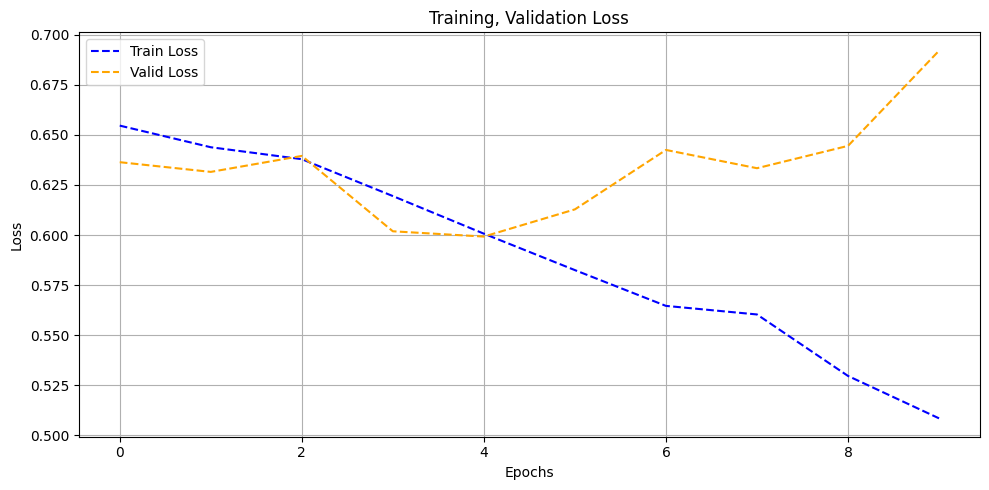

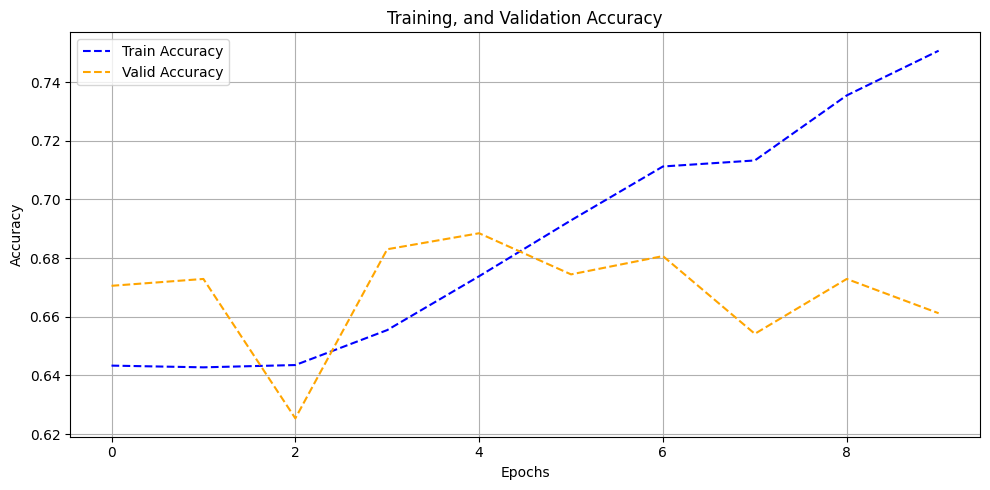

In [20]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='dashed', linewidth=1.5)
plt.plot(valid_losses, label='Valid Loss', color='orange', linestyle='dashed', linewidth=1.5)
# plt.plot(len(train_losses)-1, test_loss, marker='x', markersize=10, color='red', label='Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or display the plot
# plt.savefig('loss_plot.png')
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Train Accuracy', color='blue', linestyle='dashed', linewidth=1.5)
plt.plot(valid_accs, label='Valid Accuracy', color='orange', linestyle='dashed', linewidth=1.5)
# plt.plot(len(train_accs)-1, test_acc, marker='x', markersize=10, color='red', label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save or display the plot
# plt.savefig('accuracy_plot.png')
plt.show()
